In [1]:
import os.path

import pandas as pd
from OpenAiWrapper import OpenAiWrapper
import Utils
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import math

import seaborn as sns
from wordcloud import WordCloud



If you are working on a different dataset than praw_hot_submissions_preprocessed.csv, the embeddings for all tokens need to be retrieved via the OpenAI Embeddings API. For that a valid openAI Key has to be specified

In [2]:
#Utils.openAi_api_key = your API Key

In [6]:
def replaceEmptyList(x):
    if x is np.nan:
        return list()
    else:
        return literal_eval(x)

In [18]:
# Load the dataset
df = pd.read_csv('../dataframes/praw_hot_submissions_preprocessed.csv', converters={Utils.col_title_tokens: literal_eval})

# replace empty entries
df[Utils.col_text_tokens] = df[Utils.col_text_tokens].apply(replaceEmptyList)
df[Utils.col_text_token_string] = df[Utils.col_text_token_string].replace(np.nan, '')
df[Utils.col_title_token_string] = df[Utils.col_title_token_string].replace(np.nan, '')

# combine the tokens and strings:
df[Utils.col_combined_tokens] =  df[Utils.col_title_tokens] + df[Utils.col_text_tokens]
df[Utils.col_combined_tokens_string] = df[Utils.col_title_token_string] + ' ' + df[Utils.col_text_token_string]

# Use a Tfidf-Vectorizer to obtain all TF-IDF values for tokens/posts
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df[Utils.col_combined_tokens_string].tolist())

# If an embeddingsfile exists, load it, otherwise retrieve all embeddings from OpenAI
if not os.path.exists('../dataframes/embeddings_hot.csv'):
    openAi = OpenAiWrapper()
    print(len(tfidf_vectorizer.get_feature_names()))
    embeddings = openAi.getEmbeddingVector(tfidf_vectorizer.get_feature_names())
    embeddings.to_csv('../dataframes/embeddings_hot.csv')
else:
    embeddings = pd.read_csv('../dataframes/embeddings_hot.csv')
    embeddings.set_index('tokens', inplace=True)

embeddings.head()


9458


0         1         2         3     \
tokens                                                                   
000previousplayskipmutecurrent -0.040003 -0.011194 -0.014572 -0.020922   
00125                          -0.027713  0.001028  0.013335 -0.027953   
050                             0.000008 -0.010577  0.004153 -0.040721   
060606                         -0.003334 -0.001416  0.011314 -0.044623   
10                              0.010772 -0.007636  0.012072 -0.027749   

                                    4         5         6         7     \
tokens                                                                   
000previousplayskipmutecurrent -0.023742  0.023505 -0.035787 -0.025836   
00125                          -0.022523  0.010640 -0.020330 -0.012412   
050                            -0.019594  0.024500 -0.006348 -0.015232   
060606                         -0.030668  0.025456 -0.007812  0.005264   
10                              0.006009  0.019976 -0.040888 -0.012134   

                                    8         9     ...      1526      1527  \
tokens                                              ...                       
000previousplayskipmutecurrent -0.033498 -0.024203  ...  0.003692  0.009505   
00125                           0.008513  0.005377  ...  0.007737 -0.016357   
050                            -0.016403 -0.009574  ...  0.000293  0.000362   
060606                         -0.001594  0.000299  ...  0.003351 -0.004085   
10                             -0.013668 -0.018711  ...  0.022343 -0.007697   

                                    1528      1529      1530      1531  \
tokens                                                                   
000previousplayskipmutecurrent  0.007509 -0.024119  0.014460  0.022597   
00125                           0.045742 -0.026964  0.000601  0.010974   
050                             0.026186 -0.035509 -0.009644  0.016723   
060606                          0.018575 -0.030999 -0.010108  0.030475   
10                              0.010676 -0.033019 -0.014253  0.037366   

                                    1532      1533      1534      1535  
tokens                                                                  
000previousplayskipmutecurrent -0.007942 -0.013434  0.018578 -0.008430  
00125                           0.013709 -0.005363 -0.008440 -0.013776  
050                             0.006599 -0.017950 -0.014842 -0.002162  
060606                         -0.006316 -0.003108  0.006702 -0.011542  
10                             -0.001943 -0.018628 -0.003345 -0.025369  

[5 rows x 1536 columns]

In [50]:
# calculates embedding by summing and averaging over the single token embeddings
def embedd_submissions(x):
    sum = np.zeros(1536)
    if len(x) <= 0:
        return sum
    count = 0
    for token in x:
        if token.lower() in embeddings.index:
            sum += embeddings.loc[token.lower()].to_numpy()
            count += 1
            continue
        if token in embeddings.index:
            sum += embeddings.loc[token].to_numpy()
            count += 1

    return sum / count

In [51]:

df['embedded_submission'] = df[Utils.col_title_tokens].apply(embedd_submissions)
df['embedded_submission'].head()

0    [-0.013485316652804613, -0.012519005487168519,...
1    [-0.008727292750134237, -0.01469727601054021, ...
2    [-0.009430617870142063, -0.010319437521199385,...
3    [-0.00959603488445282, -0.010294231260195375, ...
4    [-0.005233909589151153, -0.01571304079455634, ...
Name: embedded_submission, dtype: object

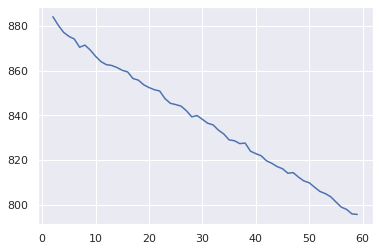

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns

#clustering with tfidf values

tfidf_matrix_np = tfidf_matrix.toarray()
cluster_range = range(2,60)
inertia = []

for k in cluster_range:
    model = KMeans(n_clusters=k)
    model.fit(tfidf_matrix_np)
    inertia.append(model.inertia_)


sns.set()
plt.plot(cluster_range, inertia)


In [22]:
k = 30
model_tfidf = KMeans(n_clusters=k, random_state=42)
model_tfidf.fit(tfidf_matrix_np)

KMeans(n_clusters=30, random_state=42)

In [23]:
# A function returning all post indices contained in a specific cluster
def ClusterIndicesNumpy(clustNum, labels_array): #numpy
    return np.where(labels_array == clustNum)[0]

In [47]:
# Find top 3 biggest clusters
doc_per_clusters = []
for i in range(k):
    doc_per_clusters.append(np.count_nonzero(model_tfidf.labels_ == i))

indices = np.argpartition(np.array(doc_per_clusters), -3)[-3:]
topk = np.flip(indices[np.argsort(np.array(doc_per_clusters)[indices])])
topk


array([13, 25,  3])

In [64]:
def printWordCloudForClusterTfidf(i):
    cluster = ClusterIndicesNumpy(i, model_tfidf.labels_)
    token_list = []
    for postId in cluster:
        post = df.iloc[postId][Utils.col_combined_tokens]
        #get tokens and tfidf scores for document
        feature_index = tfidf_matrix[postId,:].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[postId, x] for x in feature_index])
        for word, score in [(tfidf_vectorizer.get_feature_names()[i], s) for (i, s) in tfidf_scores]:
            #set word size (amount) according to tfidf scores (higher tfidf results in larger word)
            s = int(math.floor(score * 100))
            if(s < 50):
                continue
            token_list.extend([word] * s)

    if len(token_list) <= 0:
        pass
    text = ' '.join(token_list)
    wordcloud = WordCloud(background_color="white", collocations=False).generate(text)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

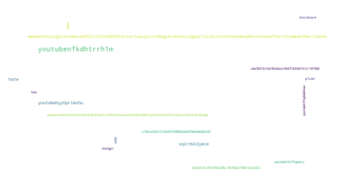

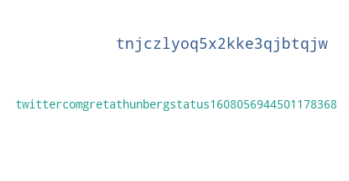

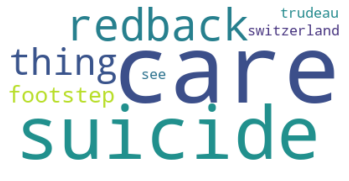

In [65]:
for i in topk:
    printWordCloudForClusterTfidf(i)

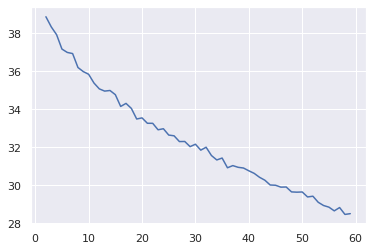

In [52]:
# clustering with embeddings
post_embeddings = np.zeros((len(df),1536))
for postIdx in range(len(df)):
    post_embeddings[postIdx] = df['embedded_submission'][postIdx]

cluster_range = range(2,60)
inertia = []

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(post_embeddings)
    inertia.append(model.inertia_)


sns.set()
plt.plot(cluster_range, inertia)

In [53]:
k = 30
model_embedd = KMeans(n_clusters=k, random_state=42)
model_embedd.fit(post_embeddings)

KMeans(n_clusters=30, random_state=42)

In [69]:
# Find top 3 biggest clusters
doc_per_clusters = []
for i in range(k):
    doc_per_clusters.append(np.count_nonzero(model_embedd.labels_ == i))

indices = np.argpartition(np.array(doc_per_clusters), -3)[-3:]
topk = np.flip(indices[np.argsort(np.array(doc_per_clusters)[indices])])
topk


array([23, 24,  1])

In [70]:
def printClustersWithWordCloudEmbeddings(i):
    cluster2 = ClusterIndicesNumpy(i, model_embedd.labels_)
    token_list = []
    for postId in cluster2:
        post = df.iloc[postId][Utils.col_combined_tokens]
        for token in post:
            token_list.append(token.lower())

    text = ' '.join(token_list)
    wordcloud = WordCloud(background_color="white", collocations=False, height=1000, width=1200).generate(text)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

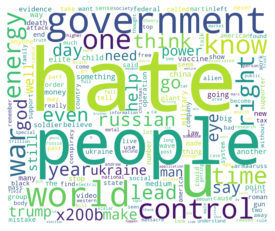

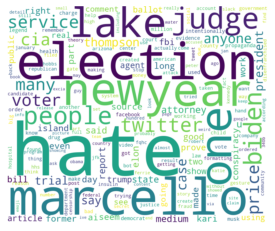

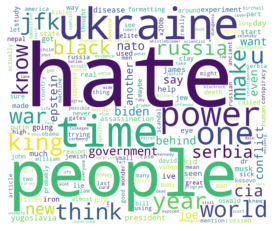

In [71]:
for i in topk:
    printClustersWithWordCloudEmbeddings(i)

In [72]:
# Calculate average similarity of clusters in embedded model
cluster_similarities_embedd = []
from sklearn.metrics.pairwise import cosine_similarity

for i in range(k):
    post_embeddings = []
    for postId in ClusterIndicesNumpy(i, model_embedd.labels_):
        post = df.iloc[postId]['embedded_submission']
        post_embeddings.append(post)

    post_embeddings = np.array(post_embeddings)
    similarity = 1.0
    if(len(post_embeddings) > 1):
        similarity = np.average(cosine_similarity(post_embeddings))
    cluster_similarities_embedd.append(similarity)

cluster_similarities_embedd = np.array(cluster_similarities_embedd)
print(cluster_similarities_embedd)
np.average(cluster_similarities_embedd)


[1.         0.94767999 0.96671862 0.95662031 0.94484867 1.
 0.94815999 1.         1.         0.9607362  0.95784596 1.
 0.92882651 1.         0.96862107 1.         0.94860033 0.95985318
 1.         1.         0.95246849 0.9030609  0.95481331 0.96618863
 0.9697676  1.         1.         0.9334233  1.         0.96104398]


0.97097590101405

In [73]:
# Calculate average similarity of clusters in embedded model
cluster_similarities_tfidfs = []
for i in range(k):
    docs_tfidfs = []
    for postId in ClusterIndicesNumpy(i, model_tfidf.labels_):
        post = df.iloc[postId]['title_tokens']
        #get tokens and tfidf scores for document
        docvec = tfidf_matrix[postId,:].toarray()[0]
        docs_tfidfs.append(docvec)

    docs_tfidfs = np.array(docs_tfidfs)
    similarity = 1.0
    if(len(docs_tfidfs) > 1):
        similarity = np.average(cosine_similarity(docs_tfidfs))
    cluster_similarities_tfidfs.append(similarity)

cluster_similarities_tfidfs = np.array(cluster_similarities_tfidfs)
print(cluster_similarities_tfidfs)
np.average(cluster_similarities_tfidfs)

[0.07641939 0.0769656  0.06411102 0.03367501 0.07051723 0.03002678
 0.05831039 0.06496467 0.07683032 0.08725066 0.06278207 0.10622768
 0.08239383 0.01805863 0.06675482 0.12184637 0.09279435 0.06022474
 0.05929221 0.17852911 0.0793689  0.16037926 0.06405658 0.08811925
 0.18042332 0.04612459 0.10835047 0.13951658 0.09506633 0.06003817]


0.08364727713790661

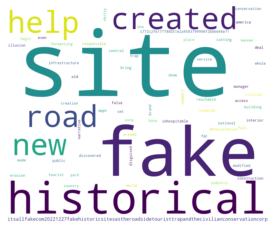

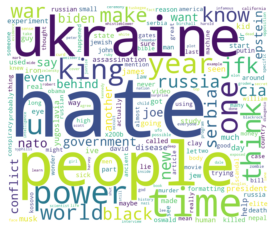

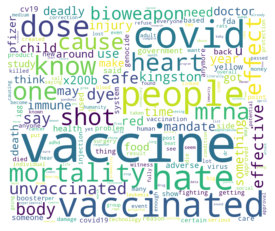

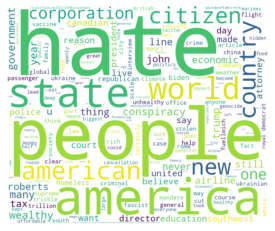

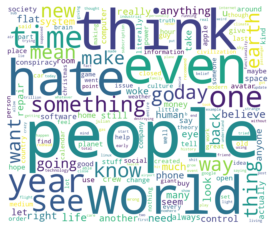

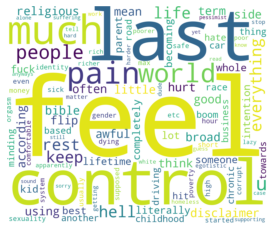

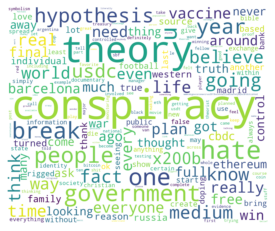

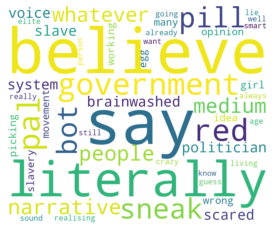

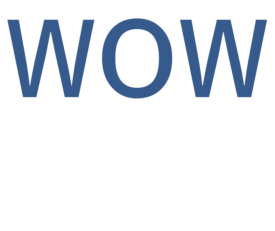

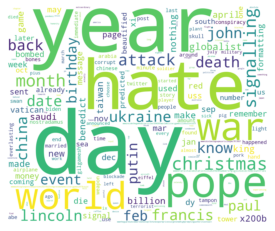

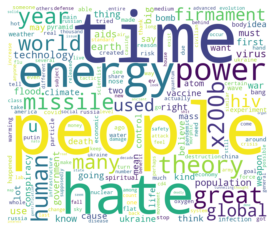

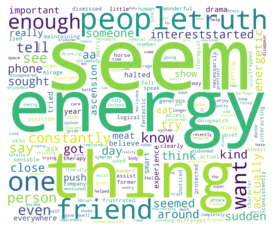

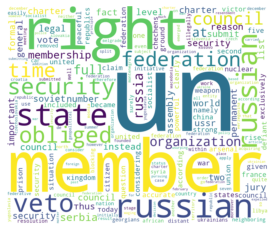

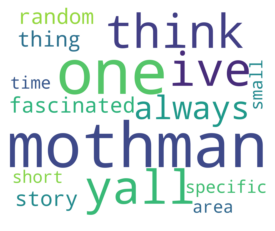

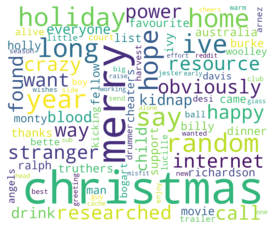

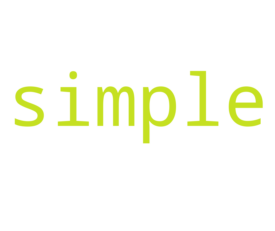

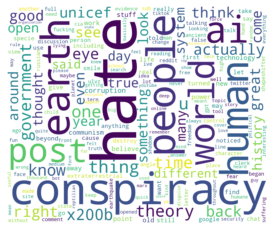

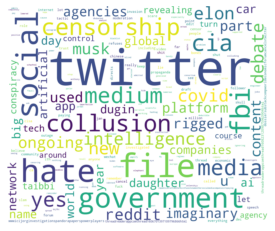

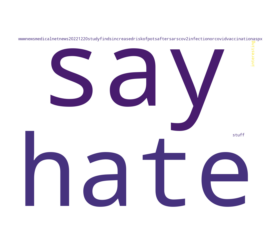

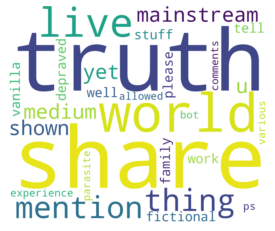

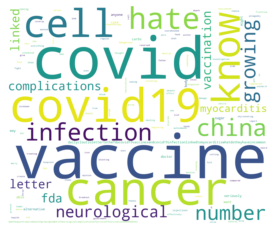

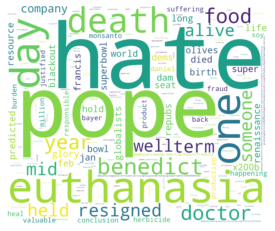

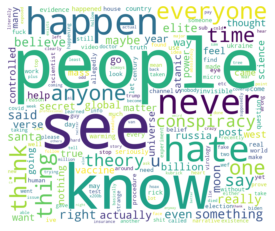

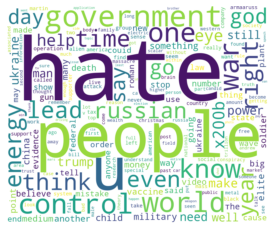

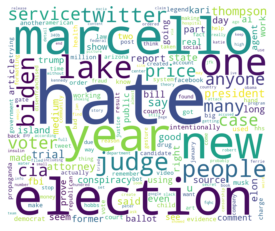

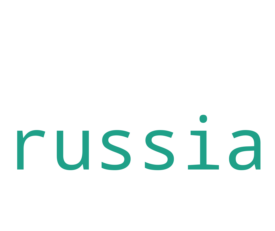

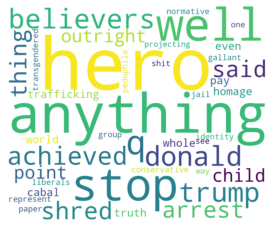

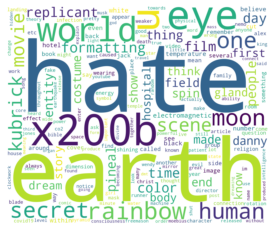

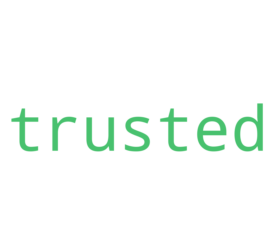

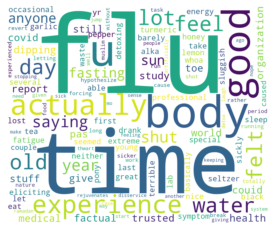

In [74]:
for i in range(k):
    printClustersWithWordCloudEmbeddings(i)

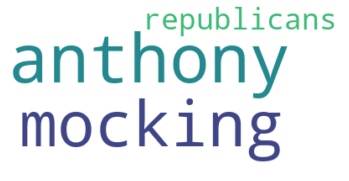

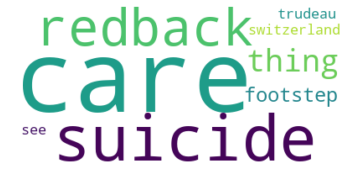

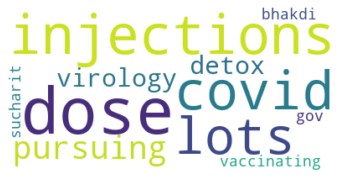

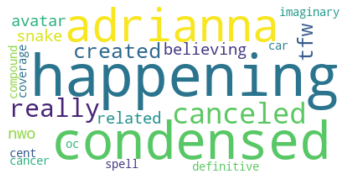

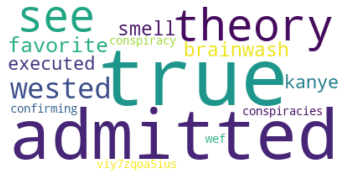

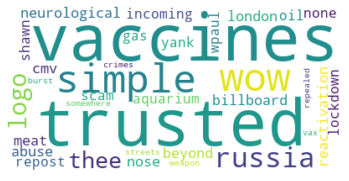

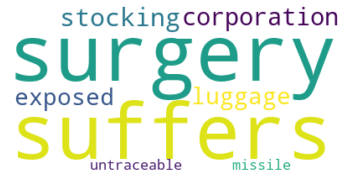

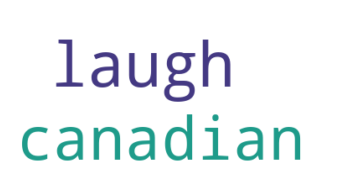

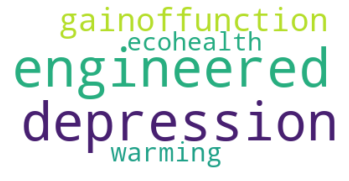

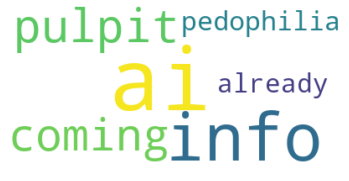

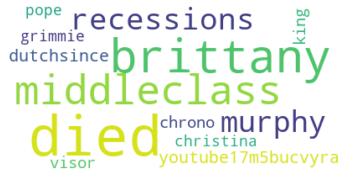

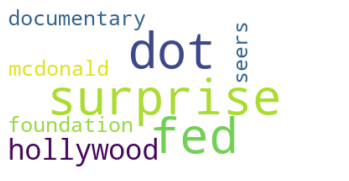

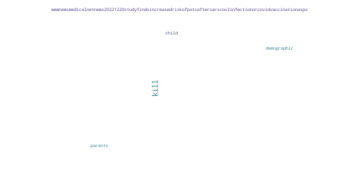

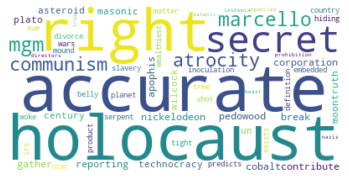

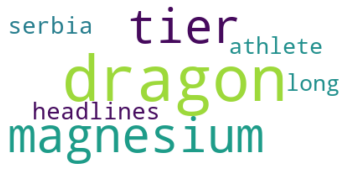

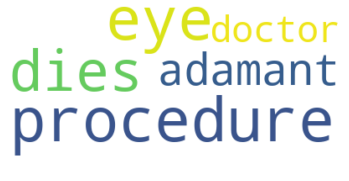

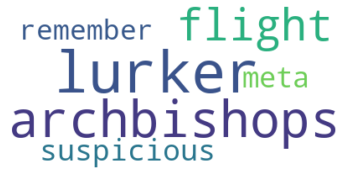

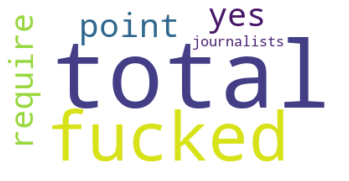

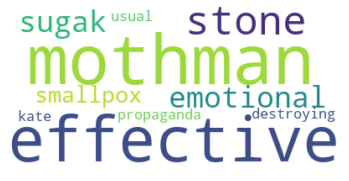

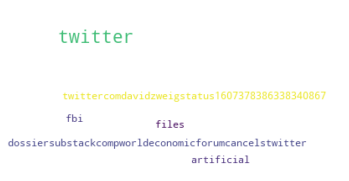

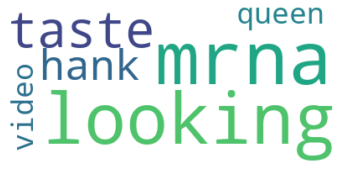

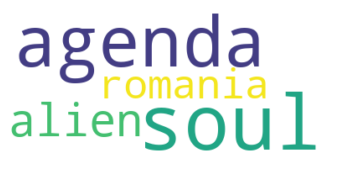

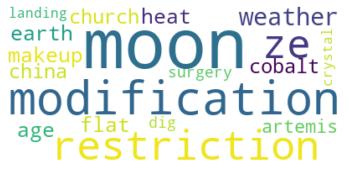

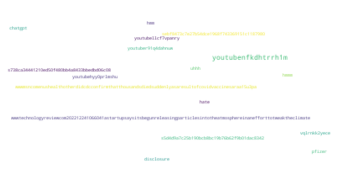

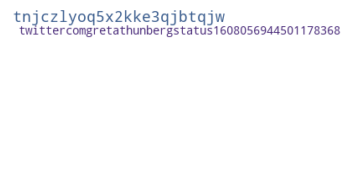

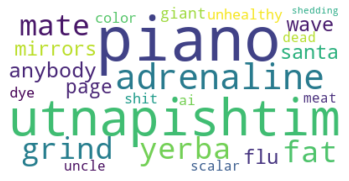

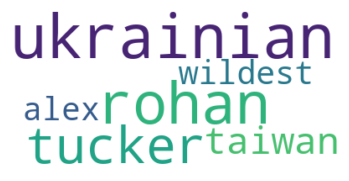

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [75]:
for i in range(k):
    printWordCloudForClusterTfidf(i)